<a href="https://colab.research.google.com/github/1941012176/DDoS-Attack-detection/blob/main/Classification_of_Attacks_on_UNSW_nb15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install prettytable
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.2 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import pickle
from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

%matplotlib inline


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
saved_dict = {}

In [12]:
dfs = []
for i in range(1,5):
  path ='/content/drive/MyDrive/UNSW-NB15/UNSW-NB15_{}.csv'
  dfs.append(pd.read_csv(path.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)

In [13]:


df_col = pd.read_csv('/content/drive/MyDrive/UNSW-NB15/NUSW-NB15_features.csv', encoding= 'ISO-8859-1')

In [14]:
df_col['Name'] = df_col['Name'].apply(lambda x:x.strip().replace(' ','').lower())

In [15]:
all_data.columns = df_col['Name']

In [16]:
saved_dict['columns']=df_col['Name'][df_col['Name']!='label'].tolist()

In [17]:
del df_col

In [18]:
all_data.shape

(2540047, 49)

In [19]:
all_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


## **Data Cleaning and Preprocessing:**

In [20]:
train, test = train_test_split(all_data,test_size=0.3, random_state=16)

In [21]:
del all_data

In [22]:


print(train.shape,'\n,', test.shape)

(1778032, 49) 
, (762015, 49)


In [23]:
train.isnull().sum()

,0
Name,
srcip,0
sport,0
dstip,0
dsport,0
proto,0
state,0
dur,0
sbytes,0
dbytes,0


In [24]:
train['attack_cat']=train.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())

In [25]:
train['attack_cat'].value_counts()

,count
attack_cat,
normal,1552862
generic,150906
exploits,31507
fuzzers,16914
dos,11433
reconnaissance,9764
analysis,1855
backdoor,1242
shellcode,1055


In [26]:
train['ct_flw_http_mthd']=train.ct_flw_http_mthd.fillna(value=0)
train['is_ftp_login'].value_counts()

,count
is_ftp_login,
0.0,746536
1.0,30329
4.0,109
2.0,21


In [27]:
train['is_ftp_login']=(train.is_ftp_login.fillna(value=0)).astype(int)

In [28]:
train.isnull().sum().sum()

0

In [29]:
train.columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload',
       'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'label'],
      dtype='object', name='Name')

### **Class Distribution:**

In [30]:
train_0, train_1 = train['label'].value_counts()[0]/len(train.index), train['label'].value_counts()[1]/len(train.index)
test_0, test_1 = test['label'].value_counts()[0]/len(test.index), test['label'].value_counts()[1]/len(test.index)

In [31]:
print("In Train: there are {} % of class 0 and {} % of class 1".format(train_0,train_1))
print("In Test: there are {} % of class 0 and {} % of class 1".format(test_0,test_1))

In Train: there are 0.8733599845222133 % of class 0 and 0.12664001547778667 % of class 1
In Test: there are 0.8738699369434985 % of class 0 and 0.1261300630565015 % of class 1


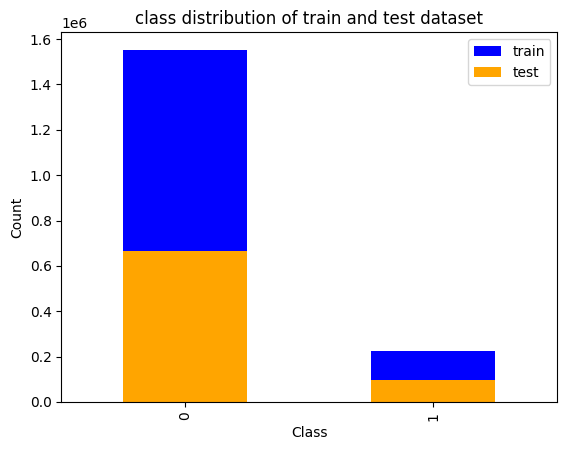

In [32]:
plt.figure()
plt.title("class distribution of train and test dataset")
train['label'].value_counts().plot(kind="bar", color='b',label="train")
test['label'].value_counts().plot(kind="bar", color='orange',label="test")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()

In [33]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 1499013)

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1778032 entries, 81030 to 2079982
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit           

In [35]:
train.dtypes.value_counts()

,count
int64,29
float64,11
object,9


In [36]:
train.select_dtypes(exclude=np.number).columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'ct_ftp_cmd', 'attack_cat'],
      dtype='object', name='Name')

In [37]:
train['ct_ftp_cmd'].unique()

array([0, ' ', 1, '1', '0', 5, 2, 3, 4, '4', 6, '2', 8], dtype=object)

In [38]:
train.select_dtypes(exclude=np.number).columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'ct_ftp_cmd', 'attack_cat'],
      dtype='object', name='Name')

In [39]:
train.select_dtypes(include=np.number).columns

Index(['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'sload',
       'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'label'],
      dtype='object', name='Name')

In [40]:
saved_dict['binary_col']=['is_sm_ips_ports' , 'is_ftp_login']

In [41]:
for col in 'is_sm_ips_ports', 'is_ftp_login':
  print(train[col].value_counts())
  print()

is_sm_ips_ports
0    1775116
1       2916
Name: count, dtype: int64

is_ftp_login
0    1747573
1      30329
4        109
2         21
Name: count, dtype: int64



In [42]:
train['is_ftp_login']=np.where(train['is_ftp_login']>1, 1, train['is_ftp_login'])


In [43]:
train['is_ftp_login'].value_counts()

,count
is_ftp_login,
0,1747573
1,30459


In [44]:
train['service']=train['service'].apply(lambda x:"None" if x=="-" else x)
train['service'].value_counts()

,count
service,
None,872286
dns,547094
http,144555
ftp-data,88310
smtp,57160
ftp,34293
ssh,32897
pop3,1076
dhcp,124


In [45]:
train['attack_cat'].nunique()

11

In [46]:
train['attack_cat'].value_counts()

,count
attack_cat,
normal,1552862
generic,150906
exploits,31507
fuzzers,16914
dos,11433
reconnaissance,9764
analysis,1855
backdoor,1242
shellcode,1055


In [47]:
train['attack_cat'] = train['attack_cat'].replace('backdoors','backdoor',regex=True).apply(lambda x: x.strip().lower())

In [48]:
train.shape, test.shape

((1778032, 49), (762015, 49))

In [49]:
train.to_csv('./train_alldata_EDA.csv', index=False)
test.to_csv('./test_alldata_EDA.csv', index=False)

In [50]:
pickle.dump(saved_dict, open('./final_ipynb', 'wb'))

### **LOADING DATA FROM DISK**

In [51]:
train=pd.read_csv('./train_alldata_EDA.csv')
test=pd.read_csv('./test_alldata_EDA.csv')

In [52]:
train.shape, test.shape

((1778032, 49), (762015, 49))

In [53]:
normal = train[train['label']==0]
anomaly = train[train['label']==1]

In [54]:
def multi_corr(col1, col2="label", df=train):
  corr = df[[col1, col2]].corr().iloc[0,1]
  log_corr = df[col1].apply(np.log1p).corr(df[col2])

  print("Correlation: {}\nlog_Correlation: {}".format(corr,log_corr))

In [55]:
def corr(col1, col2="label", df=train):
  return df[[col1, col2]].corr.iloc[0,1]

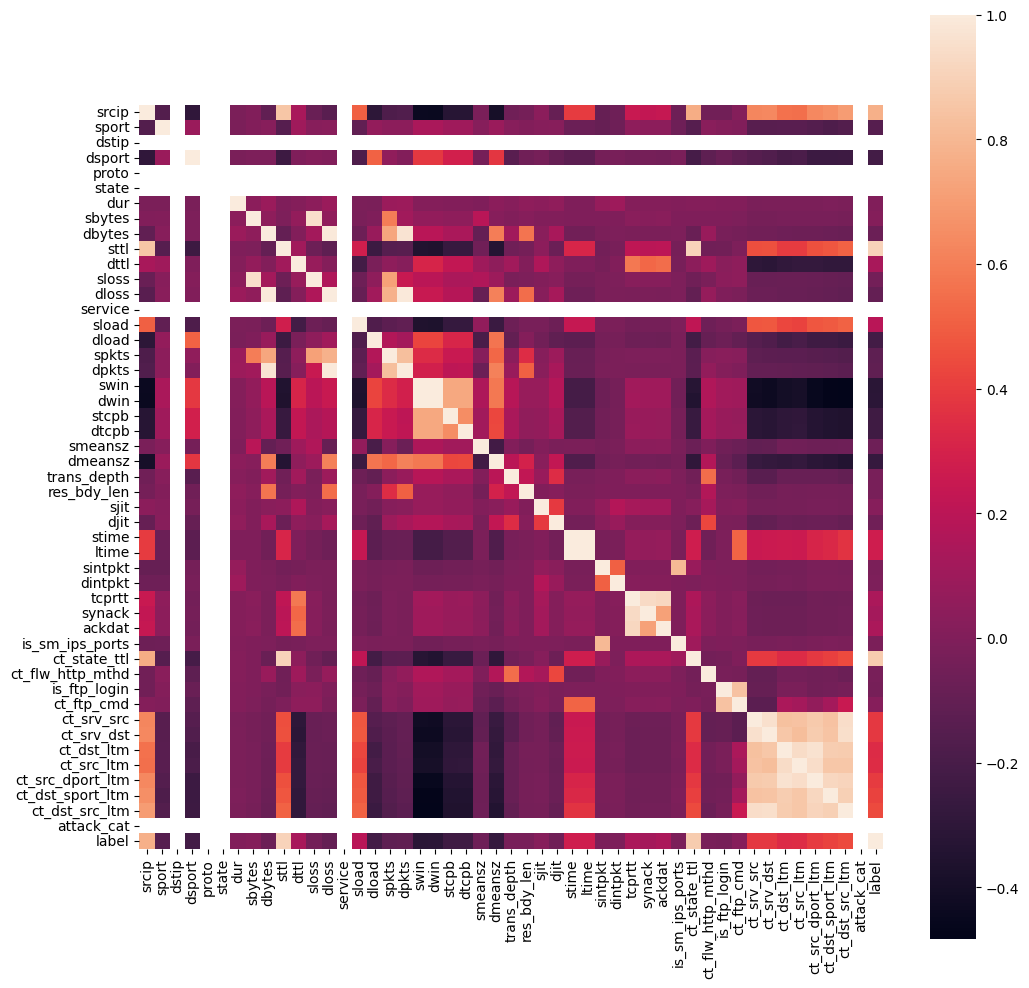

In [56]:

!pip install ipaddress

import ipaddress
import pandas as pd

def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return 0


train['srcip'] = train['srcip'].apply(ip_to_int)

for col in ['dstip', 'dsport']:
    train[col] = pd.to_numeric(train[col], errors='coerce')
    train[col] = train[col].apply(lambda x: int(x, 16) if isinstance(x, str) and x.startswith('0x') else x)
    train[col] = pd.to_numeric(train[col], errors='coerce')


corr_mat = train.apply(pd.to_numeric, errors='coerce').corr(method='pearson')

plt.figure(figsize=(12, 12))
sns.heatmap(corr_mat, square=True)
plt.show()

In [57]:
limit = 0.9
columns = corr_mat.columns
for i in range(corr_mat.shape[0]):
    for j in range(i+1, corr_mat.shape[0]):
      if corr_mat.iloc[i, j] >=0.9:
        print(f"{columns[i]:20s}{columns[j]:20s}{corr_mat.iloc[i,j]}")


sbytes              sloss               0.9515464133660682
dbytes              dloss               0.9912941785427634
dbytes              dpkts               0.9705744719061106
sttl                ct_state_ttl        0.9058027624589845
sttl                label               0.9043459910087561
dloss               dpkts               0.9921743916746946
swin                dwin                0.9971933359586712
stime               ltime               0.9999999998073185
tcprtt              synack              0.9332414134584021
tcprtt              ackdat              0.9202047490089745
ct_srv_src          ct_srv_dst          0.956721026945663
ct_srv_src          ct_dst_src_ltm      0.942148711061324
ct_srv_dst          ct_dst_src_ltm      0.9510250540010916
ct_dst_ltm          ct_src_ltm          0.9384612565049639
ct_dst_ltm          ct_src_dport_ltm    0.9601144948755526
ct_src_ltm          ct_src_dport_ltm    0.9453045008443021
ct_src_dport_ltm    ct_dst_sport_ltm    0.9214458874161181

In [58]:
'''
sns.set_style("whitegrid")
sns.pairplot(data=train, vars=['sbytes', 'sloss'])
plt.show()
'''

'\nsns.set_style("whitegrid")\nsns.pairplot(data=train, vars=[\'sbytes\', \'sloss\'])\nplt.show()\n'

In [59]:
''''
sns.set_style('whitegrid')
sns.pairplot(train, vars=['dpkts', 'dbytes', 'dloss'])
plt.show()
'''

"'\nsns.set_style('whitegrid')\nsns.pairplot(train, vars=['dpkts', 'dbytes', 'dloss'])\nplt.show()\n"

In [60]:
'''
sns.set_style('whitegrid')
sns.pairplot(train, vars=['sttl', 'ct_state_ttl', 'label'])
plt.show()
'''

"\nsns.set_style('whitegrid')\nsns.pairplot(train, vars=['sttl', 'ct_state_ttl', 'label'])\nplt.show()\n"

In [61]:
'''
sns.set_style('whitegrid')
sns.pairplot(train, vars=['swin', 'dwin'])
plt.show()
'''

"\nsns.set_style('whitegrid')\nsns.pairplot(train, vars=['swin', 'dwin'])\nplt.show()\n"

In [62]:
def col_countplot(col, train_data=train):
    fig, ax = plt.subplots(figsize=(8,4))
    sns.set_style('whitegrid')

    ax = sns.countplot(x=col, hue='label', data=train_data)
    ax.legend(loc="upper right", labels=('normal', 'attack'))
    ax.set_title("train data")
    plt.xticks(rotation=45)
    plt.show()

In [63]:
def dual_plot(col, data1=normal, data2=anomaly, label1='normal', label2='anomaly', method=None):

    if method != None:
        sns.set_style('whitegrid')
        sns.distplot(data1[col].apply(method), label=label1, hist=False, rug=True)
        sns.distplot(data2[col].apply(method), label=label2, hist=False, rug=True)
    else:
        sns.set_style('whitegrid')
        sns.distplot(data1[col], label=label1, hist=False, rug=True)
        sns.distplot(data2[col], label=label2, hist=False, rug=True)
    plt.legend()

In [64]:
def reduce_column(s, to_keep):

    s = s.lower().strip()
    if s not in to_keep:
        return "others"
    else:
        return s

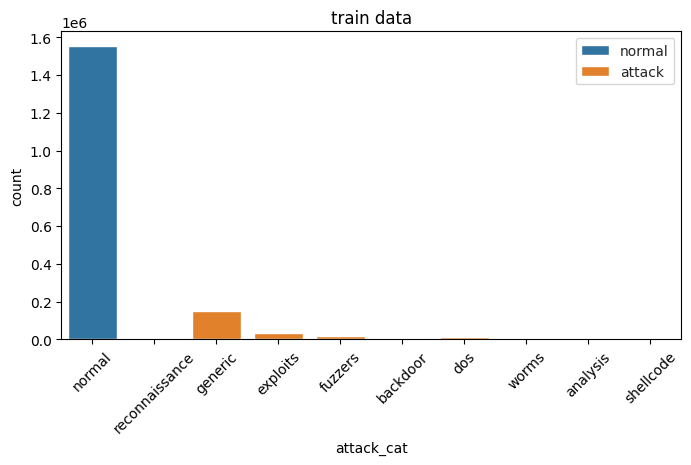

In [65]:
col_countplot('attack_cat')

In [66]:
train['proto'].nunique()

135

In [67]:
normal['proto'].nunique(), anomaly['proto'].nunique()

(9, 129)

In [68]:
train['proto'].value_counts().head(10)*100/train.shape[0]

,count
proto,
tcp,58.858108
udp,38.983550
unas,0.639640
arp,0.397631
ospf,0.306800
sctp,0.061810
icmp,0.020303
any,0.015916
gre,0.013104


In [69]:
to_keep = ['tcp', 'udp', 'unas', 'arp', 'ospf']
train['proto_reduced'] = train['proto'].apply(reduce_column, args=(to_keep,))

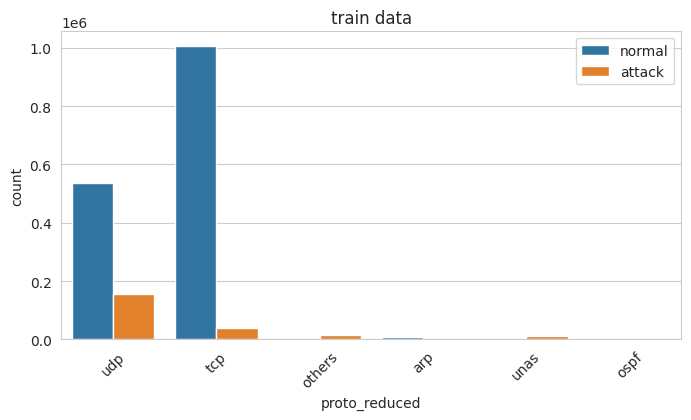

In [70]:
col_countplot('proto_reduced')

In [71]:
train['service'].nunique()

12

In [72]:
train['service'].value_counts()

,count
service,
dns,547094
http,144555
ftp-data,88310
smtp,57160
ftp,34293
ssh,32897
pop3,1076
dhcp,124
ssl,109


**FEATURE ENGINEERING**

In [73]:
train = pd.read_csv("/content/train_alldata_EDA.csv")
test = pd.read_csv("/content/test_alldata_EDA.csv")

In [74]:
def multi_corr(col1, col2="label", df=train):
  corr = df[[col1, col2]].corr().iloc[0,1]
  log_corr = df[col1].apply(np.log1p).corr(df[col2])

  print("Correlation: {}\nlog_Correlation : {}".format(corr, log_corr))

In [75]:
def corr(col1, col2="label", df=train):
  return df[[col1, col2]].corr().iloc[0,1]

In [76]:
corr_matrix = train.select_dtypes(include=np.number).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [77]:
print(to_drop)

['sloss', 'dloss', 'dpkts', 'dwin', 'ltime', 'ct_srv_dst', 'ct_src_dport_ltm', 'ct_dst_src_ltm']


In [78]:
saved_dict['corr_col'] = to_drop

In [79]:
train.drop(to_drop, axis=1, inplace=True)

In [80]:
train.shape, test.shape

((1778032, 41), (762015, 49))

In [81]:
train['network_bytes'] = train['sbytes'] + train['dbytes']

In [82]:
train.shape, test.shape

((1778032, 42), (762015, 49))

In [83]:
train.drop(['srcip', 'sport', 'dstip', 'dsport', 'attack_cat'], axis=1, inplace=True)

In [84]:
saved_dict['to_drop'] = ['srcip', 'sport', 'dstip', 'dsport', 'attack_cat']

In [85]:
train.shape, test.shape

((1778032, 37), (762015, 49))

In [86]:
col_unique_values = train.nunique()

In [87]:
col = col_unique_values[col_unique_values>200].index

In [88]:
for column in col:
  print("{:-^30}".format(column))
  multi_corr(column)

-------------dur--------------
Correlation: 0.0019274028701131475
log_Correlation : -0.032544137564606564
------------sbytes------------
Correlation: 0.010344749695229565
log_Correlation : -0.3561631555898454
------------dbytes------------
Correlation: -0.07641408324436148
log_Correlation : -0.5193868283741543
------------sload-------------
Correlation: 0.19211948100086756
log_Correlation : 0.34746601450349657
------------dload-------------
Correlation: -0.21978094390126515
log_Correlation : -0.6033545881626403
------------spkts-------------
Correlation: -0.12200425437154418
log_Correlation : -0.3163533826967569
------------stcpb-------------
Correlation: -0.23365153315010911
log_Correlation : -0.31355632221428964
------------dtcpb-------------
Correlation: -0.23346071773809843
log_Correlation : -0.31340064798121187
-----------smeansz------------
Correlation: -0.06517990378993671
log_Correlation : -0.15111450989648462
-----------dmeansz------------
Correlation: -0.27230605607442226
log

In [89]:
log1p_col = ['dur', 'sbytes', 'dbytes', 'sload', 'dload', 'spkts', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'sjit', 'djit', 'network_bytes']


In [90]:
saved_dict['log1p_col'] = log1p_col

In [91]:
mode_dict = train.mode().iloc[0].to_dict()

In [92]:
def log1p_transform(col, df=train):

    new_col = col+'_log1p'
    df[new_col] = df[col].apply(np.log1p)
    df.drop(col, axis=1, inplace=True)

In [93]:
for col in log1p_col:
    log1p_transform(col, df=train)


In [94]:

train.shape

(1778032, 37)

In [95]:

train.columns

Index(['proto', 'state', 'sttl', 'dttl', 'service', 'swin', 'trans_depth',
       'res_bdy_len', 'stime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack',
       'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_dst_sport_ltm', 'label', 'dur_log1p', 'sbytes_log1p',
       'dbytes_log1p', 'sload_log1p', 'dload_log1p', 'spkts_log1p',
       'stcpb_log1p', 'dtcpb_log1p', 'smeansz_log1p', 'dmeansz_log1p',
       'sjit_log1p', 'djit_log1p', 'network_bytes_log1p'],
      dtype='object')

In [96]:
train.shape, test.shape

((1778032, 37), (762015, 49))

In [97]:
x_train, y_train = train.drop(columns=['label']), train['label']
x_test, y_test = test.drop(columns=['label']), test['label']
print(x_train.shape, y_train.shape)
print()
print(x_test.shape, y_test.shape)

(1778032, 36) (1778032,)

(762015, 48) (762015,)


In [98]:
pickle.dump((x_train, y_train), open('/content/final_ipynb', 'wb'))
pickle.dump((x_test, y_test), open('/content/final_ipynb', 'wb'))

In [99]:
cat_col = ['proto', 'service', 'state']
num_col = list(set(x_train.columns) - set(cat_col))

In [100]:
saved_dict['cat_col'] = cat_col
saved_dict['num_col'] = num_col

In [101]:
x_train.head()

,proto,state,sttl,dttl,service,swin,trans_depth,res_bdy_len,stime,sintpkt,...,sload_log1p,dload_log1p,spkts_log1p,stcpb_log1p,dtcpb_log1p,smeansz_log1p,dmeansz_log1p,sjit_log1p,djit_log1p,network_bytes_log1p
0,udp,INT,254,0,NaN,0,0,0,1421930643,33.479000,...,9.275600,0.000000,1.609438,0.000000,0.000000,3.828641,0.000000,3.878042,0.000000,5.187386
1,udp,INT,60,0,dns,0,0,0,1424246229,0.008000,...,18.698312,0.000000,1.098612,0.000000,0.000000,4.890349,0.000000,0.000000,0.000000,5.579730
2,tcp,FIN,31,29,NaN,255,0,0,1421948071,0.372205,...,14.105347,16.314201,3.713572,20.196135,21.733479,4.174387,6.313548,0.000000,3.012070,10.152883
3,tcp,FIN,31,29,ftp,255,0,0,1421971944,16.144740,...,10.258074,10.501435,3.970292,21.803017,20.494420,4.043051,4.248495,7.264606,3.984562,8.806124
4,tcp,FIN,31,29,NaN,255,0,0,1421963050,1.218800,...,13.339317,13.412088,2.833213,20.673269,21.855078,4.574711,4.521789,4.309533,1.138118,8.066208


In [102]:
# Standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
for col in num_col:
    x_train[col] = pd.to_numeric(x_train[col], errors='coerce')

scaler = scaler.fit(x_train[num_col])

In [103]:
x_train[num_col]= scaler.transform(x_train[num_col])

In [104]:
x_train.head()

,proto,state,sttl,dttl,service,swin,trans_depth,res_bdy_len,stime,sintpkt,...,sload_log1p,dload_log1p,spkts_log1p,stcpb_log1p,dtcpb_log1p,smeansz_log1p,dmeansz_log1p,sjit_log1p,djit_log1p,network_bytes_log1p
0,udp,INT,2.561444,-0.717760,NaN,-1.196045,-0.225343,-0.089113,-1.172764,-0.057567,...,-1.383776,-1.879995,-0.704801,-1.190007,-1.189697,-1.137341,-1.850553,0.204270,-0.899657,-1.229918
1,udp,INT,-0.037542,-0.717760,dns,-1.196045,-0.225343,-0.089113,0.868469,-0.069616,...,1.614925,-1.879995,-1.080734,-1.190007,-1.189697,0.565988,-1.850553,-0.995343,-0.899657,-1.062092
2,tcp,FIN,-0.426051,-0.041365,NaN,0.836096,-0.225343,-0.089113,-1.157401,-0.069485,...,0.153252,0.988351,0.843701,0.741629,0.888925,-0.582651,0.881301,-0.995343,0.170283,0.894089
3,tcp,FIN,-0.426051,-0.041365,ftp,0.836096,-0.225343,-0.089113,-1.136357,-0.063807,...,-1.071111,-0.033644,1.032630,0.895318,0.770420,-0.793357,-0.012242,1.251851,0.515730,0.318009
4,tcp,FIN,-0.426051,-0.041365,NaN,0.836096,-0.225343,-0.089113,-1.144197,-0.069180,...,-0.090531,0.478104,0.195816,0.787264,0.900555,0.059601,0.106012,0.337745,-0.495378,0.001507


In [105]:
from sklearn.preprocessing import OneHotEncoder


service_ = OneHotEncoder()
proto_ = OneHotEncoder()
state_ = OneHotEncoder()

# Fit the encoders and transform the data for each column
for col, ohe in zip(['service', 'proto', 'state'], [service_, proto_, state_]):
    # Fit the encoder on the original data
    ohe = ohe.fit(x_train[col].values.reshape(-1,1))
    # Transform the data and create a new DataFrame with the encoded columns
    x = ohe.transform(x_train[col].values.reshape(-1,1))
    # Convert categories to strings
    categories = [str(i) for i in ohe.categories_[0]]
    tmp_df = pd.DataFrame(x.todense(), columns=[col+'_'+ i for i in categories])
    # Concatenate the new DataFrame with the original DataFrame (dropping the original column)
    x_train = pd.concat([x_train.drop(col, axis=1), tmp_df], axis=1)

# Display the head of the modified DataFrame
x_train.head()

,sttl,dttl,swin,trans_depth,res_bdy_len,stime,sintpkt,dintpkt,tcprtt,synack,...,state_INT,state_MAS,state_PAR,state_REQ,state_RST,state_TST,state_TXD,state_URH,state_URN,state_no
0,2.561444,-0.717760,-1.196045,-0.225343,-0.089113,-1.172764,-0.057567,-0.055099,-0.136439,-0.128893,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.037542,-0.717760,-1.196045,-0.225343,-0.089113,0.868469,-0.069616,-0.055099,-0.136439,-0.128893,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.426051,-0.041365,0.836096,-0.225343,-0.089113,-1.157401,-0.069485,-0.054857,-0.121383,-0.107394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.426051,-0.041365,0.836096,-0.225343,-0.089113,-1.136357,-0.063807,-0.044512,-0.120830,-0.107159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.426051,-0.041365,0.836096,-0.225343,-0.089113,-1.144197,-0.069180,-0.054358,-0.123351,-0.110421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
file_path = '/content/final_ipynb'

In [108]:
pickle.dump(scaler, open(file_path+'scaler.pkl', 'wb'))
pickle.dump(saved_dict, open(file_path+'saved_dict.pkl', 'wb'))
pickle.dump(mode_dict, open(file_path+'mode_dict.pkl', 'wb'))

In [111]:
pickle.dump(proto_, open(file_path+'ohe_proto.pkl', 'wb'))
pickle.dump(service_, open(file_path+'ohe_service.pkl', 'wb'))
pickle.dump(state_, open(file_path+'ohe_state.pkl', 'wb'))


In [112]:
pickle.dump((x_train, y_train), open(file_path+'final_train.pkl', 'wb'))

In [113]:
def clean_data(data):

    numerical_col = data.select_dtypes(include=np.number).columns
    categorical_col = data.select_dtypes(exclude=np.number).columns


    for col in data.columns:
        val = mode_dict[col]
        data[col] = data[col].fillna(value=val)
        data[col] = data[col].replace(' ', value=val)
        data[col] = data[col].apply(lambda x:"None" if x=="-" else x)


        if col in saved_dict['binary_col']:
            data[col] = np.where(data[col]>1, val, data[col])


    bad_dtypes = list(set(categorical_col) - set(saved_dict['cat_col']))
    for bad_col in bad_dtypes:
        data[col] = data[col].astype(float)

    return data

In [114]:
def apply_log1p(data):

    for col in saved_dict['log1p_col']:
        new_col = col + '_log1p'  # New col name
        data[new_col] = data[col].apply(np.log1p)  # Creating new column on transformed data
        data.drop(col, axis=1, inplace=True)  # Removing old columns
    return data

In [115]:
def standardize(data):

    data[saved_dict['num_col']] = scaler.transform(data[saved_dict['num_col']])
    return data

In [168]:
def ohencoding(data):
    X = ohe_service.transform(data['service'].values.reshape(-1, 1))
    Xm = ohe_proto.transform(data['proto'].values.reshape(-1, 1))
    Xmm = ohe_state.transform(data['state'].values.reshape(-1, 1))


    data = pd.concat([data,
                      pd.DataFrame(Xm.toarray(), columns=['proto_'+i for i in ohe_proto.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in ohe_service.categories_[0]]),
                      pd.DataFrame(Xmm.toarray(), columns=['state_'+i for i in ohe_state.categories_[0]])],
                      axis=1)


    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)

    return data

In [169]:
saved_dict = pickle.load(open(file_path+'saved_dict.pkl', 'rb'))
# Mode value of all the columns
mode_dict = pickle.load(open(file_path+'mode_dict.pkl', 'rb'))
# Stanardscaler object
scaler = pickle.load(open(file_path+'scaler.pkl', 'rb'))

In [170]:
print(f'Shape of the dataframe: {x_test.shape}')
print(f'Length of new columns: {len(saved_dict["columns"])}')

if x_test.shape[1] != len(saved_dict['columns']):
  # Find missing columns in x_test compared to saved_dict['columns']
  missing_cols = set(saved_dict['columns']) - set(x_test.columns)
  print(f'Missing columns in x_test: {missing_cols}')

  # Add missing columns to x_test with default value 0
  for col in missing_cols:
    x_test[col] = 0

  # Ensure the order of columns in x_test matches saved_dict['columns']
  x_test = x_test[saved_dict['columns']]

x_test.columns = saved_dict['columns']

Shape of the dataframe: (762015, 23)
Length of new columns: 48
Missing columns in x_test: {'dloss', 'dpkts', 'sload', 'sjit', 'sbytes', 'dstip', 'ct_src_dport_ltm', 'dmeansz', 'sloss', 'ltime', 'dtcpb', 'attack_cat', 'sport', 'dur', 'srcip', 'dsport', 'djit', 'dwin', 'stcpb', 'spkts', 'smeansz', 'ct_srv_dst', 'ct_dst_src_ltm', 'dload', 'dbytes'}


In [171]:
ohe_proto = pickle.load(open(file_path+'ohe_proto.pkl', 'rb'))
ohe_service = pickle.load(open(file_path+'ohe_service.pkl', 'rb'))
ohe_state = pickle.load(open(file_path+'ohe_state.pkl', 'rb'))
x_test.shape

x_test.reset_index(drop=True, inplace=True)
x_test.shape

x_test.columns

x_test.columns = saved_dict['columns']

In [172]:
if 'dbytes' in x_test.columns and 'sbytes' in x_test.columns:
  x_test['network_bytes'] = x_test['dbytes'] + x_test['sbytes']
else:

  print("Error: 'dbytes' or 'sbytes' column not found in DataFrame.")

In [173]:
dropable_col = saved_dict['to_drop'] + saved_dict['corr_col']

# Check if columns exist before dropping
existing_cols = set(x_test.columns)
cols_to_drop = set(dropable_col)

# Find columns that exist in both lists
common_cols = existing_cols.intersection(cols_to_drop)

# Drop only the common columns
x_test.drop(columns=list(common_cols), inplace=True)

In [174]:
x_test.shape

(762015, 36)

In [175]:
x_test = clean_data(x_test)

In [176]:
x_test.shape

(762015, 36)

In [177]:
def apply_log1p(data):
    for col in saved_dict['log1p_col']:
        if col in data.columns: #Check if the column exists before proceeding
            new_col = col + '_log1p'
            data[new_col] = data[col].apply(np.log1p)
            data.drop(col, axis=1, inplace=True)
    return data

In [178]:
x_test = apply_log1p(x_test)

In [179]:
x_test.shape

(762015, 36)

In [180]:
x_test.columns

Index(['proto', 'state', 'sttl', 'dttl', 'service', 'swin', 'trans_depth',
       'res_bdy_len', 'stime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack',
       'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_dst_sport_ltm', 'dur_log1p', 'sbytes_log1p', 'dbytes_log1p',
       'sload_log1p', 'dload_log1p', 'spkts_log1p', 'stcpb_log1p',
       'dtcpb_log1p', 'smeansz_log1p', 'dmeansz_log1p', 'sjit_log1p',
       'djit_log1p', 'network_bytes_log1p'],
      dtype='object')

In [181]:
def apply_log1p(data):
    for col in saved_dict['log1p_col']:
        if col in data.columns:
            new_col = col + '_log1p'
            data[new_col] = data[col].apply(np.log1p)
            data.drop(col, axis=1, inplace=True)
            saved_dict['num_col'].remove(col)
            saved_dict['num_col'].append(new_col)
    return data

In [182]:
'''x_test.replace(' ', np.nan, inplace=True)


x_test = standardize(x_test)'''

"x_test.replace(' ', np.nan, inplace=True)\n\n\nx_test = standardize(x_test)"

In [183]:

x_test.head()

,proto,state,sttl,dttl,service,swin,trans_depth,res_bdy_len,stime,sintpkt,...,sload_log1p,dload_log1p,spkts_log1p,stcpb_log1p,dtcpb_log1p,smeansz_log1p,dmeansz_log1p,sjit_log1p,djit_log1p,network_bytes_log1p
0,udp,CON,-0.847060,-0.718724,dns,-1.205576,-0.83437,-0.089115,-1254.632023,-0.069644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,udp,CON,-0.847060,-0.718724,dns,-1.205576,-0.83437,-0.089115,-1254.632023,-0.069644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,udp,INT,-0.841856,-0.734501,dns,-1.205576,-0.83437,-0.089115,-1254.632021,-0.069644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tcp,FIN,-0.847060,-0.718724,dns,-1.189382,-0.83437,-0.089115,-1254.632023,-0.069644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,udp,CON,-0.847060,-0.718724,dns,-1.205576,-0.83437,-0.089115,-1254.632021,-0.069644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [187]:
def ohencoding(data):
    saved_dict = load_obj('saved_dict')

    ohe_proto = ColumnTransformer([('ohe_proto',OneHotEncoder(handle_unknown='ignore',sparse_output=False),['proto'])],
                                remainder='passthrough')
    ohe_service = ColumnTransformer([('ohe_service',OneHotEncoder(handle_unknown='ignore',sparse_output=False),['service'])],
                                remainder='passthrough')
    ohe_state = ColumnTransformer([('ohe_state',OneHotEncoder(handle_unknown='ignore',sparse_output=False),['state'])],
                                remainder='passthrough')


    Xm = ohe_proto.fit_transform(data)
    X = ohe_service.fit_transform(data)
    Xmm = ohe_state.fit_transform(data)

    data = pd.concat([data,
                      pd.DataFrame(Xm.toarray(), columns=['proto_'+str(i) for i in ohe_proto.categories_[0]]), # Cast i to string type
                      pd.DataFrame(X.toarray(), columns=['service_'+str(i) for i in ohe_service.categories_[0]]), # Cast i to string type
                      pd.DataFrame(Xmm.toarray(), columns=['state_'+str(i) for i in ohe_state.categories_[0]])], # Cast i to string type
                      axis=1)

    data.drop(['proto','service','state'], axis=1, inplace=True)
    return data

In [192]:
def get_final_data(data, saved_dict=saved_dict, mode_dict=mode_dict):

    if len(data.columns) != len(saved_dict['columns']):
        print(f"Warning: Mismatch in number of columns. Existing: {len(data.columns)}, Expected: {len(saved_dict['columns'])}")
        # Handle the mismatch (e.g., return the DataFrame as is or raise an error)
        return data
    data.columns = saved_dict['columns']

    data['network_bytes'] = data['dbytes'] + data['sbytes']

    dropable_col = saved_dict['to_drop'] + saved_dict['corr_col']
    data.drop(columns=dropable_col, inplace=True)

    data = clean_data(data)
    data = apply_log1p(data)
    data = standardize(data)
    data = ohencoding(data)

In [193]:
x_test = get_final_data(x_test)


In [196]:
!pip install scipy

from scipy.sparse import csr_matrix

x_test = x_test.apply(pd.to_numeric, errors='coerce')

x_test_csr = csr_matrix(x_test.values)
col = x_test.columns

x_test = pd.DataFrame.sparse.from_spmatrix(x_test_csr, columns=col)

In [197]:
x_train.shape, y_train.shape

((1778032, 197), (1778032,))

In [198]:

x_test.shape, y_test.shape

((762015, 36), (762015,))

In [200]:
print(x_train.columns)
print(x_test.columns)

Index(['sttl', 'dttl', 'swin', 'trans_depth', 'res_bdy_len', 'stime',
       'sintpkt', 'dintpkt', 'tcprtt', 'synack',
       ...
       'state_INT', 'state_MAS', 'state_PAR', 'state_REQ', 'state_RST',
       'state_TST', 'state_TXD', 'state_URH', 'state_URN', 'state_no'],
      dtype='object', length=197)
Index(['proto', 'state', 'sttl', 'dttl', 'service', 'swin', 'trans_depth',
       'res_bdy_len', 'stime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack',
       'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_dst_sport_ltm', 'dur_log1p', 'sbytes_log1p', 'dbytes_log1p',
       'sload_log1p', 'dload_log1p', 'spkts_log1p', 'stcpb_log1p',
       'dtcpb_log1p', 'smeansz_log1p', 'dmeansz_log1p', 'sjit_log1p',
       'djit_log1p', 'network_bytes_log1p'],
      dtype='object')


In [202]:
def false_alarm_rate(y_true, y_pred):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FPR = fp / (fp + tn)  # False positive rate
    FNR = fn / (fn + tp)  # False negetive rate
    return (FPR+FNR)/2  # False alarm rate

In [203]:
def hyperparam_tuning(clf, parameters, x, y, method='gridsearch', cv=None):

    # initialization
    scoring = {'auc':'roc_auc',
               'f1':'f1',
               'FAR':make_scorer(false_alarm_rate, greater_is_better=False)}  # using custom scoring function FAR.

    # param tuning
    if method=='gridsearch':
        # As we are using multi scoring, So we need to point refit to scoring function with which we want to evaluate score
        tuning_clf = GridSearchCV(clf, parameters, scoring=scoring, refit='auc',
                                  cv=cv, verbose=3, return_train_score=True)
        result = tuning_clf.fit(x, y)

    elif method=='randomsearch':
        tuning_clf = RandomizedSearchCV(clf, parameters, scoring=scoring, refit='auc',
                                        cv=cv, verbose=3, return_train_score=True)
        result = tuning_clf.fit(x, y)

    return result

In [204]:
def result_visualization(tuned_clf, parameters, param1=None, param2=None):
    """
    Utility function to plot the results obtained after hyper parameter tuning
    """
    # getting train and test scores to plot
    train_score = tuned_clf.cv_results_['mean_train_auc']
    test_score = tuned_clf.cv_results_['mean_test_auc']

    # print results
    print("Best Score: {}".format(tuned_clf.best_score_))
    print("Best Parameters: {}".format(tuned_clf.best_params_))

    # Want to visualize score with 2 params, plot heatmap of the 3 variables
    if param2 is not None:
        # heatmap
        train_cmap=sns.light_palette("green")
        test_cmap=sns.light_palette("blue")

        # Figure and axis
        fig = plt.figure(figsize=(20,5))
        train_ax = fig.add_subplot(1,2,1)
        test_ax = fig.add_subplot(1,2,2)

        # train heatmap
        sns.heatmap(train_score.reshape(len(parameters[param1]), len(parameters[param2])),
                    cmap=train_cmap, annot=True, fmt='.4f', ax=train_ax,
                    xticklabels=parameters[param2], yticklabels=parameters[param1])

        # test heapmap
        sns.heatmap(test_score.reshape(len(parameters[param1]), len(parameters[param2])),
                    cmap=test_cmap, annot=True, fmt='.6f', ax=test_ax,
                    xticklabels=parameters[param2], yticklabels=parameters[param1])

        # axis labels and plot title
        train_ax.set_title("Train hyperparam heatmap")
        train_ax.set_xlabel(param2)
        train_ax.set_ylabel(param1)

        test_ax.set_title("Test hyperparam heatmap")
        test_ax.set_xlabel(param2)
        test_ax.set_ylabel(param1)
        plt.show()

    # Want to visualize score with one param, simply plot score and param
    else:
        plt.figure(figsize=(10,5))
        plt.plot(np.log10(parameters[param1]), train_score, label="train")
        plt.plot(np.log10(parameters[param1]), test_score, label="test")

        # Plot for train data
        for i, txt in enumerate(train_score):
            plt.annotate((parameters[param1][i], np.round(txt, 3)), (np.log10(parameters[param1])[i], train_score[i]))

        # Plot for test data
        for i, txt in enumerate(test_score):
            plt.annotate((parameters[param1][i], np.round(txt, 3)), (np.log10(parameters[param1])[i], test_score[i]))

        plt.xlabel(param1)
        plt.ylabel('performance')
        plt.grid()
        plt.legend()
        plt.show()

In [205]:
def evaluate_result(clf, x_train, y_train, x_test, y_test, model_name):
    """
    Utility function to get result on test data from best found classifier using hyper parameter tuning.
    Print the accuracy and False Alarm Rate for both train and test.
    Plot confusion matrix of train and test.
    """
    cmap=sns.light_palette("blue")
    labels= ['non-attack', 'attack']

    # Training te best model
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)  # prediction on train data
    y_test_pred = clf.predict(x_test)  # prediction on test data

    # auc curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

    # Scores of train dataset
    train_auc = auc(train_fpr, train_tpr)
    train_f1 = f1_score(y_train, y_train_pred)
    train_far = false_alarm_rate(y_train, y_train_pred)

    # Scores of test dataset
    test_auc = auc(test_fpr, test_tpr)
    test_f1 = f1_score(y_test, y_test_pred)
    test_far = false_alarm_rate(y_test, y_test_pred)

    # Printing the result as a table
    x = PrettyTable()
    x.field_names = ['Dataset', 'Model', 'AUC', 'F1-score', 'False Alarm Rate']
    x.add_row(['Train', model_name, train_auc, train_f1, train_far])
    x.add_row(['Test', model_name, test_auc, test_f1, test_far])
    print(x)

    # Plot AUC curve
    plt.figure()
    plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc}")
    plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc}")
    plt.grid()
    plt.legend()
    plt.show()

    # Confusion martix of train and test
    # Train confusion matrix
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")

    # Test confusion matrix
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    plt.show()

    # Returning scores of test data
    return clf, test_auc, test_f1, test_far

In [212]:
!pip install scikit-learn
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.impute import SimpleImputer

# Assuming x_train is a pandas DataFrame
x_train = x_train.fillna(0) # Replace NaN values with 0

x_train_csr = csr_matrix(x_train)

# 'log' is not a valid value for the loss parameter. Use 'log_loss' instead.
clf = SGDClassifier(loss='log_loss', penalty='l2')
param = {'alpha':np.logspace(-6, 1, 8)}  # Values of alpha

lr_clf = hyperparam_tuning(clf, param, x_train_csr, y_train, cv=3)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END alpha=1e-06; FAR: (train=-0.016, test=-0.016) auc: (train=0.999, test=0.999) f1: (train=0.958, test=0.957) total time=  18.9s
[CV 2/3] END alpha=1e-06; FAR: (train=-0.010, test=-0.010) auc: (train=0.999, test=0.999) f1: (train=0.955, test=0.955) total time=  14.8s
[CV 3/3] END alpha=1e-06; FAR: (train=-0.009, test=-0.009) auc: (train=0.999, test=0.999) f1: (train=0.954, test=0.955) total time=  12.6s
[CV 1/3] END alpha=9.999999999999999e-06; FAR: (train=-0.021, test=-0.021) auc: (train=0.999, test=0.999) f1: (train=0.959, test=0.958) total time=   6.5s
[CV 2/3] END alpha=9.999999999999999e-06; FAR: (train=-0.022, test=-0.022) auc: (train=0.999, test=0.999) f1: (train=0.958, test=0.958) total time=   5.9s
[CV 3/3] END alpha=9.999999999999999e-06; FAR: (train=-0.011, test=-0.011) auc: (train=0.999, test=0.999) f1: (train=0.955, test=0.956) total time=   6.8s
[CV 1/3] END alpha=9.999999999999999e-05; FAR: (train=-0.0

Best Score: 0.9991867017099758
Best Parameters: {'alpha': 9.999999999999999e-06}


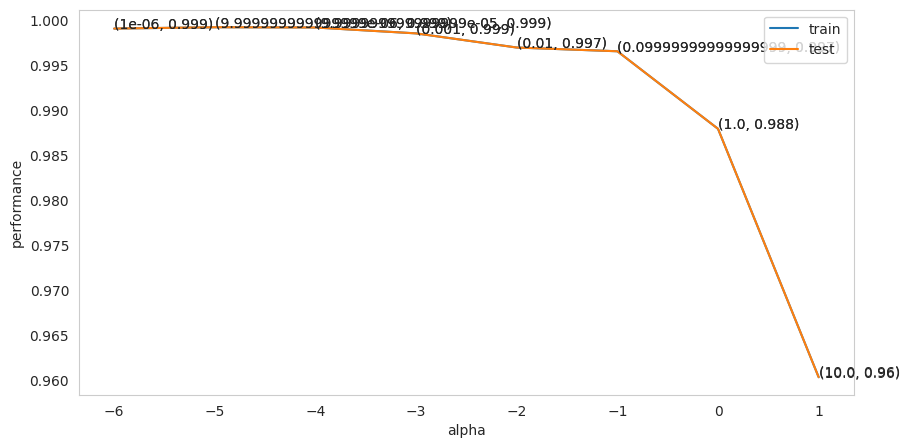

In [213]:
result_visualization(lr_clf, param, param1='alpha')

In [215]:
clf = SGDClassifier(loss='log_loss', penalty='l1') # Changed loss parameter to 'log_loss'
param = {'alpha':np.logspace(-6, 1, 8)}  # Values of alpha

lr_clf = hyperparam_tuning(clf, param, x_train_csr, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END alpha=1e-06; FAR: (train=-0.013, test=-0.013) auc: (train=0.999, test=0.999) f1: (train=0.958, test=0.956) total time=  20.2s
[CV 2/5] END alpha=1e-06; FAR: (train=-0.033, test=-0.034) auc: (train=0.999, test=0.999) f1: (train=0.952, test=0.952) total time=  20.6s
[CV 3/5] END alpha=1e-06; FAR: (train=-0.034, test=-0.034) auc: (train=0.999, test=0.999) f1: (train=0.953, test=0.952) total time=  20.4s
[CV 4/5] END alpha=1e-06; FAR: (train=-0.017, test=-0.016) auc: (train=0.999, test=0.999) f1: (train=0.957, test=0.958) total time=  19.9s
[CV 5/5] END alpha=1e-06; FAR: (train=-0.042, test=-0.041) auc: (train=0.999, test=0.999) f1: (train=0.948, test=0.949) total time=  18.9s
[CV 1/5] END alpha=9.999999999999999e-06; FAR: (train=-0.025, test=-0.026) auc: (train=0.999, test=0.999) f1: (train=0.957, test=0.955) total time=   9.8s
[CV 2/5] END alpha=9.999999999999999e-06; FAR: (train=-0.022, test=-0.023) auc: (train=0.9

Best Score: 0.999217421383036
Best Parameters: {'alpha': 1e-06}


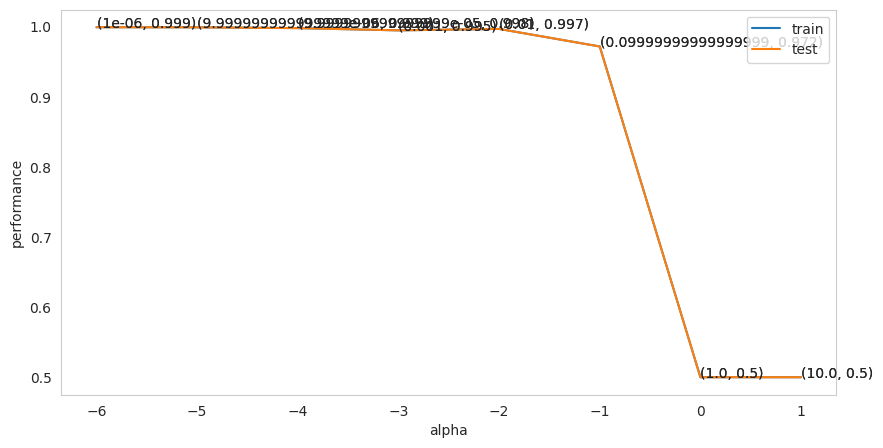

In [216]:
result_visualization(lr_clf, param, 'alpha')

+---------+-------+---------------------+--------------------+----------------------+
| Dataset | Model |         AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+---------------------+--------------------+----------------------+
|  Train  |   LR  |  0.9720927425169893 | 0.9383388182987163 | 0.027907257483010713 |
|   Test  |   LR  | 0.49951794529629573 | 0.2237653492232867 |  0.5004820547037042  |
+---------+-------+---------------------+--------------------+----------------------+


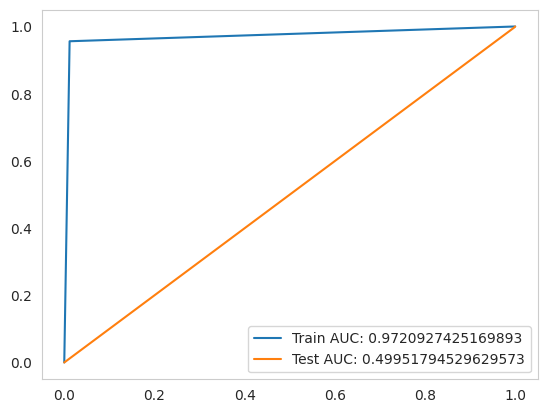

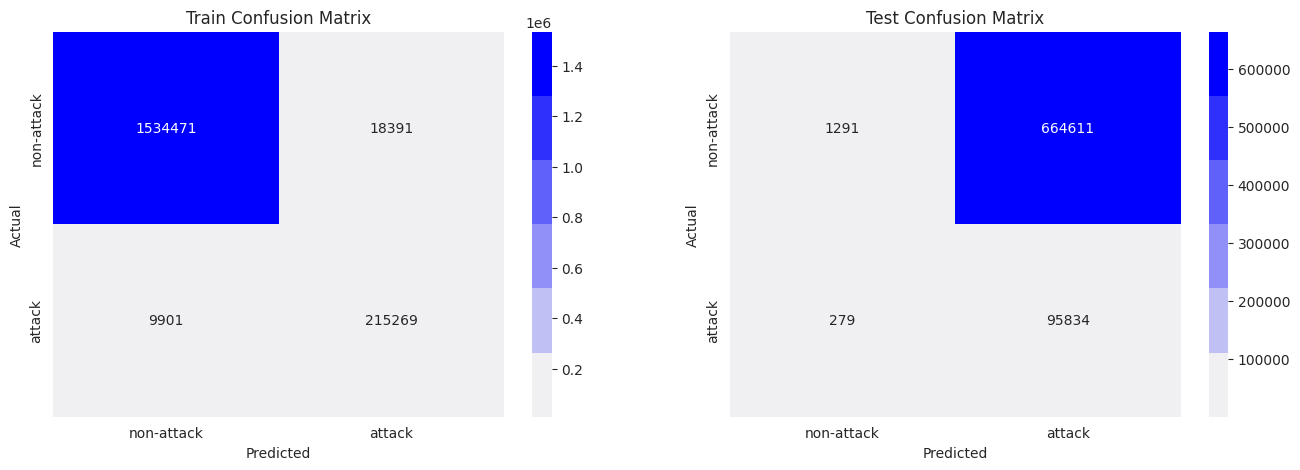

In [220]:
# Get the common columns between x_train and x_test
common_cols = x_train_cols.intersection(x_test.columns)

# Select the common columns from both DataFrames
x_train = x_train[common_cols]
x_test = x_test[common_cols]

# Impute missing values (replace NaNs with 0)
x_train = x_train.fillna(0)
x_test = x_test.fillna(0)

# Now you can proceed with fitting and prediction
lr_bst_clf = SGDClassifier(penalty='l1', alpha=1e-6)
lr_clf, lr_auc, lr_f1, lr_far = evaluate_result(lr_bst_clf, x_train, y_train, x_test, y_test, 'LR')

In [223]:
result_dict = {"name":[], "auc":[], "f1":[], "far":[]}

result_dict['name'].append("LR")
result_dict['auc'].append(lr_auc)
result_dict['f1'].append(lr_f1)
result_dict['far'].append(lr_far)

In [224]:
result_dict

{'name': ['LR'],
 'auc': [0.49951794529629573],
 'f1': [0.2237653492232867],
 'far': [0.5004820547037042]}